# Explore here

# # Banking Marketing Campaign - Logistic Regression Project
# 
# ## Project Overview
# The Portuguese bank is experiencing declining revenue and wants to identify existing customers likely to subscribe to long-term deposits. This will allow them to focus marketing efforts efficiently.
# 
# **Business Objective**: Create a ranking algorithm to predict customer subscription likelihood.
# 
# **Data Source**: [Bank Marketing Campaign Dataset](https://raw.githubusercontent.com/4GeeksAcademy/logistic-regression-project-tutorial/main/bank-marketing-campaign-data.csv)

In [5]:
# Your code here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score)

## Load and Inspect Data
# 
# We'll load the dataset and perform initial inspection to understand its structure and contents.

In [6]:
# Load dataset
url = "https://raw.githubusercontent.com/4GeeksAcademy/logistic-regression-project-tutorial/main/bank-marketing-campaign-data.csv"
print("Loading data from:", url)
data = pd.read_csv(url, sep=";")
print("Data loaded successfully!")
print("Initial shape:", data.shape)

# Show first 3 rows
data.head(3)

Loading data from: https://raw.githubusercontent.com/4GeeksAcademy/logistic-regression-project-tutorial/main/bank-marketing-campaign-data.csv
Data loaded successfully!
Initial shape: (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# ## 3. Handle Data Leakage
# 
# **Critical Step**: Remove the 'duration' column as it represents information only available AFTER a call is completed, which would create unrealistic model performance.

In [7]:
print("\nRemoving 'duration' column to prevent data leakage...")
data = data.drop(columns=['duration'])
print("New shape:", data.shape)


Removing 'duration' column to prevent data leakage...
New shape: (41188, 20)


# ## 4. Data Information & Target Variable
# 
# Let's examine the dataset information and target variable distribution.

In [8]:
# Basic info
print("\n=== Data Information ===")
data.info()

# Target variable distribution
print("\n=== Target Variable Distribution ===")
target_counts = data['y'].value_counts(normalize=True)
print(target_counts)

# Convert target to binary
print("\nConverting target variable to binary (yes=1, no=0)...")
data['y'] = (data['y'] == 'yes').astype(int)
print("Conversion complete!")



=== Data Information ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  eurib

# ## 5. Exploratory Data Analysis (EDA)
# 
# We'll perform comprehensive EDA to understand relationships in the data.

# ### 5.1 Target Distribution


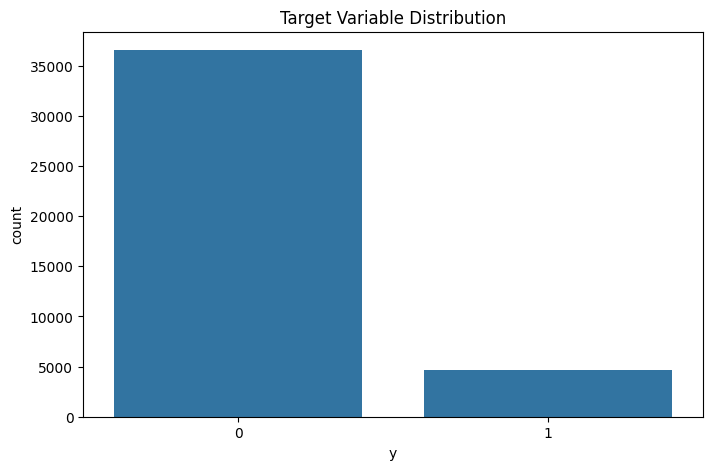

In [9]:
# Target distribution
plt.figure(figsize=(8,5))
sns.countplot(x='y', data=data)
plt.title('Target Variable Distribution')
plt.savefig('target_distribution.png', bbox_inches='tight')
plt.show()

# ### 5.2 Correlation Matrix (Numerical Features)
# 
# Examines relationships between numerical features.



Plotting correlation matrix...


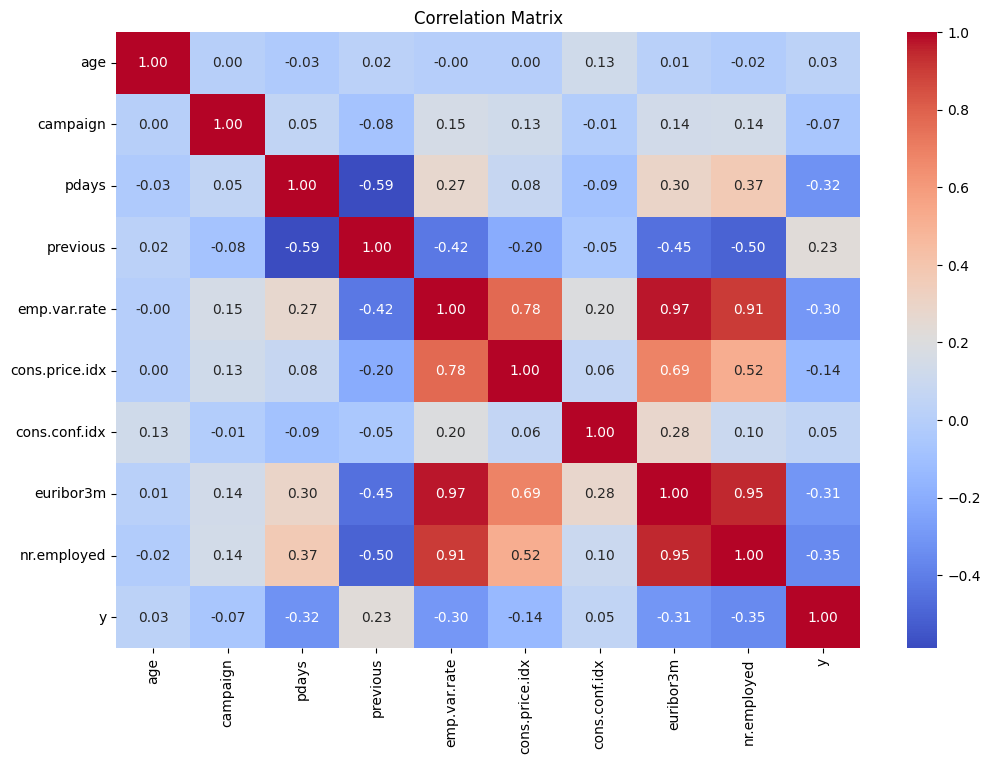

In [10]:
print("\nPlotting correlation matrix...")
num_cols = data.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(12,8))
sns.heatmap(data[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png', bbox_inches='tight')
plt.show()

# ### 5.3 Categorical Features Analysis
# 
# Analyze key categorical features against subscription status.


Analyzing categorical features...


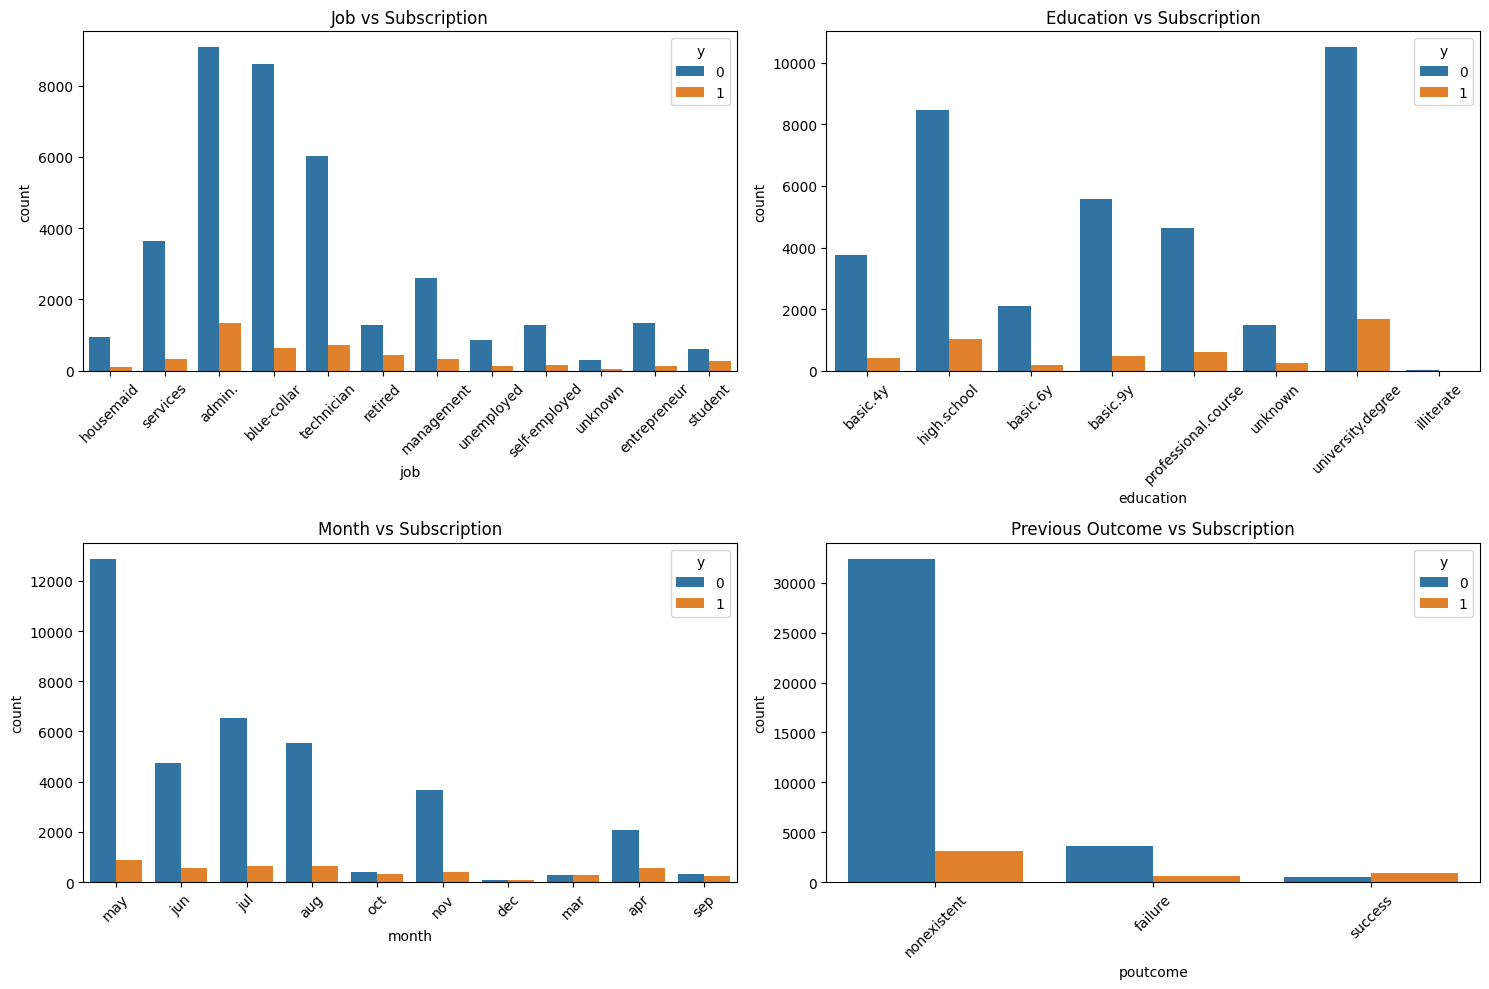

In [11]:
print("\nAnalyzing categorical features...")
fig, axes = plt.subplots(2, 2, figsize=(15,10))

# Job vs Subscription
sns.countplot(ax=axes[0,0], x='job', hue='y', data=data)
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].set_title('Job vs Subscription')

# Education vs Subscription
sns.countplot(ax=axes[0,1], x='education', hue='y', data=data)
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].set_title('Education vs Subscription')

# Month vs Subscription
sns.countplot(ax=axes[1,0], x='month', hue='y', data=data)
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].set_title('Month vs Subscription')

# Previous Outcome vs Subscription
sns.countplot(ax=axes[1,1], x='poutcome', hue='y', data=data)
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].set_title('Previous Outcome vs Subscription')

plt.tight_layout()
plt.savefig('categorical_analysis.png', bbox_inches='tight')
plt.show()

# ### 5.4 Age Distribution Analysis
# 
# Examine how age relates to subscription behavior.


Analyzing age distribution...


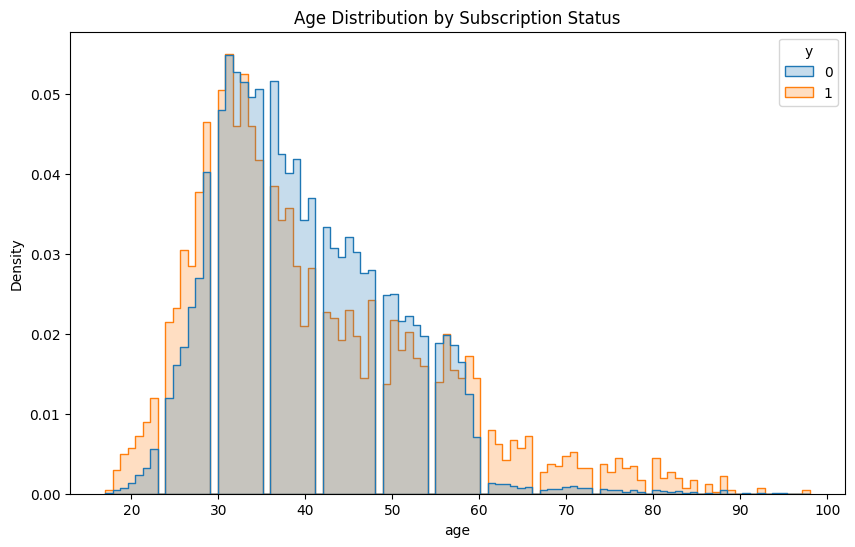

In [12]:
print("\nAnalyzing age distribution...")
plt.figure(figsize=(10,6))
sns.histplot(data=data, x='age', hue='y', element='step', stat='density', common_norm=False)
plt.title('Age Distribution by Subscription Status')
plt.savefig('age_distribution.png', bbox_inches='tight')
plt.show()

# ## 6. Data Preprocessing
# 
# Prepare data for modeling by splitting and transforming features.

In [13]:
# Separate features and target
X = data.drop(columns=['y'])
y = data['y']

# Split data
print("Splitting data into train (80%) and test (20%) sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# Identify feature types
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns

print("\nNumerical columns:", list(num_cols))
print("Categorical columns:", list(cat_cols))

# Create preprocessing pipeline
print("\nCreating preprocessing pipeline...")
preprocessor = make_column_transformer(
    (StandardScaler(), num_cols),  # Scale numerical features
    (OneHotEncoder(handle_unknown='ignore'), cat_cols),  # Encode categorical features
    remainder='passthrough'
)

# Apply preprocessing
print("Fitting preprocessor on training data...")
X_train_processed = preprocessor.fit_transform(X_train)
print("Transforming test data...")
X_test_processed = preprocessor.transform(X_test)

print(f"Processed train shape: {X_train_processed.shape}")
print(f"Processed test shape: {X_test_processed.shape}")


Splitting data into train (80%) and test (20%) sets...
Train shape: (32950, 19), Test shape: (8238, 19)

Numerical columns: ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

Creating preprocessing pipeline...
Fitting preprocessor on training data...
Transforming test data...
Processed train shape: (32950, 62)
Processed test shape: (8238, 62)


# ## 7. Baseline Model
# 
# Create and evaluate a baseline logistic regression model.


In [14]:
print("\n=== Training Baseline Model ===")
baseline_model = LogisticRegression(random_state=42, max_iter=1000)
print("Training baseline model...")
baseline_model.fit(X_train_processed, y_train)

# Make predictions
y_pred_baseline = baseline_model.predict(X_test_processed)

# Evaluate
print("\n=== Baseline Model Evaluation ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_baseline):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_baseline))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline))

# Save metrics for comparison
baseline_recall = recall_score(y_test, y_pred_baseline, pos_label=1)
baseline_precision = precision_score(y_test, y_pred_baseline, pos_label=1)


=== Training Baseline Model ===
Training baseline model...

=== Baseline Model Evaluation ===
Accuracy: 0.9009

Confusion Matrix:
[[7219   91]
 [ 725  203]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7310
           1       0.69      0.22      0.33       928

    accuracy                           0.90      8238
   macro avg       0.80      0.60      0.64      8238
weighted avg       0.88      0.90      0.88      8238



# ## 8. Balanced Model
# 
# Address class imbalance using class weighting.

In [15]:
# %%
print("\n=== Training Balanced Model ===")
balanced_model = LogisticRegression(
    random_state=42, 
    class_weight='balanced',  # Adjusts for class imbalance
    max_iter=2000
)
print("Training balanced model...")
balanced_model.fit(X_train_processed, y_train)

# Make predictions
y_pred_balanced = balanced_model.predict(X_test_processed)

# Evaluate
print("\n=== Balanced Model Evaluation (Default Threshold) ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_balanced):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_balanced))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_balanced))



=== Training Balanced Model ===
Training balanced model...

=== Balanced Model Evaluation (Default Threshold) ===
Accuracy: 0.8350

Confusion Matrix:
[[6279 1031]
 [ 328  600]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      7310
           1       0.37      0.65      0.47       928

    accuracy                           0.84      8238
   macro avg       0.66      0.75      0.69      8238
weighted avg       0.88      0.84      0.85      8238



# ## 9. Threshold Optimization
# 
# Optimize prediction threshold to maximize recall of subscribers.



=== Performing Threshold Optimization ===

Testing thresholds from 0.1 to 0.5...
Optimal threshold: 0.1000
Best recall achieved: 1.0000

=== Optimized Model Evaluation ===
Accuracy: 0.1141

Confusion Matrix:
[[  12 7298]
 [   0  928]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      7310
           1       0.11      1.00      0.20       928

    accuracy                           0.11      8238
   macro avg       0.56      0.50      0.10      8238
weighted avg       0.90      0.11      0.03      8238



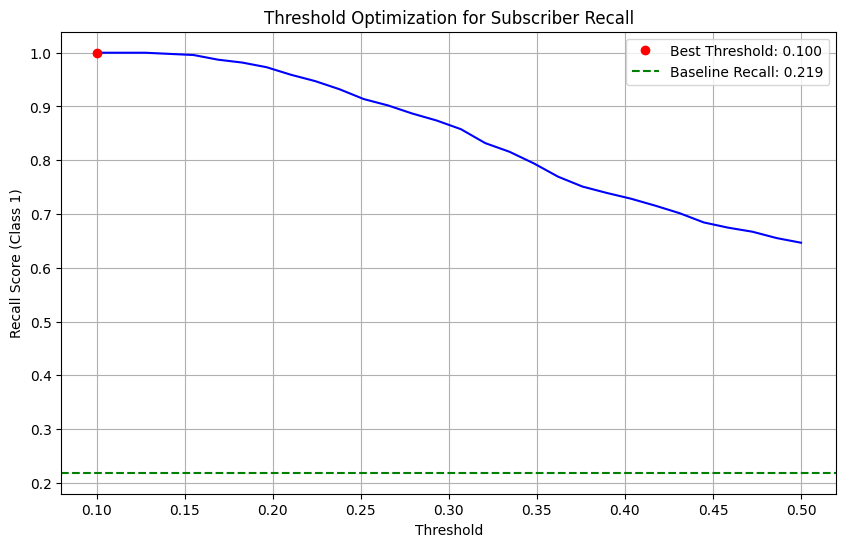

In [16]:
print("\n=== Performing Threshold Optimization ===")
y_proba_balanced = balanced_model.predict_proba(X_test_processed)[:, 1]

# Test thresholds
thresholds = np.linspace(0.1, 0.5, 30)
recall_scores = []

print("\nTesting thresholds from 0.1 to 0.5...")
for thresh in thresholds:
    y_pred_thresh = (y_proba_balanced > thresh).astype(int)
    recall = recall_score(y_test, y_pred_thresh, pos_label=1)
    recall_scores.append(recall)

# Find best threshold
best_idx = np.argmax(recall_scores)
best_threshold = thresholds[best_idx]
best_recall = recall_scores[best_idx]

print(f"Optimal threshold: {best_threshold:.4f}")
print(f"Best recall achieved: {best_recall:.4f}")

# Apply optimal threshold
y_pred_optimized = (y_proba_balanced > best_threshold).astype(int)

# Evaluate optimized model
print("\n=== Optimized Model Evaluation ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_optimized):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_optimized))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_optimized))

# Save metrics
optimized_recall = recall_score(y_test, y_pred_optimized, pos_label=1)
optimized_precision = precision_score(y_test, y_pred_optimized, pos_label=1)

# Plot results
plt.figure(figsize=(10,6))
plt.plot(thresholds, recall_scores, 'b-')
plt.plot(best_threshold, best_recall, 'ro', label=f'Best Threshold: {best_threshold:.3f}')
plt.axhline(y=baseline_recall, color='g', linestyle='--', label=f'Baseline Recall: {baseline_recall:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Recall Score (Class 1)')
plt.title('Threshold Optimization for Subscriber Recall')
plt.legend()
plt.grid(True)
plt.savefig('threshold_optimization.png', bbox_inches='tight')
plt.show()


# ## 10. Business Impact Analysis
# 
# Quantify the financial impact of our optimized model.


In [17]:
print("\n=== Business Impact Analysis ===")
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_optimized).ravel()

# Business parameters
cost_per_call = 2.50  # Estimated cost per marketing call
revenue_per_sub = 500  # Estimated revenue per subscription

# Calculate metrics
cost_savings = fp * cost_per_call
revenue_gain = tp * revenue_per_sub
net_impact = revenue_gain - cost_savings

# Baseline comparison
_, fp_base, _, tp_base = confusion_matrix(y_test, y_pred_baseline).ravel()
base_cost_savings = fp_base * cost_per_call
base_revenue_gain = tp_base * revenue_per_sub
base_net_impact = base_revenue_gain - base_cost_savings

# Print results
print("\nOptimized Model Results:")
print(f"- True Positives (Subscribers Identified): {tp}")
print(f"- False Positives (Costly Misidentifications): {fp}")
print(f"- Potential Revenue: ${revenue_gain:.2f}")
print(f"- Cost Savings: ${cost_savings:.2f}")
print(f"- NET IMPACT: ${net_impact:.2f}")

print("\nBaseline Model Results:")
print(f"- True Positives: {tp_base}")
print(f"- False Positives: {fp_base}")
print(f"- NET IMPACT: ${base_net_impact:.2f}")

print(f"\nImprovement Over Baseline: ${net_impact - base_net_impact:.2f}")



=== Business Impact Analysis ===

Optimized Model Results:
- True Positives (Subscribers Identified): 928
- False Positives (Costly Misidentifications): 7298
- Potential Revenue: $464000.00
- Cost Savings: $18245.00
- NET IMPACT: $445755.00

Baseline Model Results:
- True Positives: 203
- False Positives: 91
- NET IMPACT: $101272.50

Improvement Over Baseline: $344482.50


# ## 11. Project Summary
# 
# Key findings and achievements.

In [18]:
print("\n=== Project Summary ===")
print("Key Achievements:")
print(f"1. Improved recall for subscribers from {baseline_recall:.2%} to {optimized_recall:.2%}")
print(f"2. Increased net business impact by ${net_impact - base_net_impact:.2f}")
print("3. Identified optimal decision threshold for marketing focus")
print("\nVisualizations saved to files:")
print("- target_distribution.png: Class distribution")
print("- correlation_matrix.png: Feature correlations")
print("- categorical_analysis.png: Key categorical relationships")
print("- age_distribution.png: Age vs subscription")
print("- threshold_optimization.png: Recall optimization curve")


=== Project Summary ===
Key Achievements:
1. Improved recall for subscribers from 21.88% to 100.00%
2. Increased net business impact by $344482.50
3. Identified optimal decision threshold for marketing focus

Visualizations saved to files:
- target_distribution.png: Class distribution
- correlation_matrix.png: Feature correlations
- categorical_analysis.png: Key categorical relationships
- age_distribution.png: Age vs subscription
- threshold_optimization.png: Recall optimization curve
